In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 2022 Species-Sightings Scaling

In [2]:
%config SqlMagic.autopandas = True

In [3]:
db_file = 'data/ebird_2022.parquet'

In [4]:
sql = """
SELECT
    scientific_name,
    SUM(CAST(observation_count AS INT)) AS total_sightings
FROM 'data/ebird_2022.parquet'
WHERE observation_count != 'X'
GROUP BY scientific_name
ORDER BY total_sightings DESC
"""
results = duckdb.sql(sql)

In [5]:
sql = """SELECT
    scientific_name,
    observer_id,
    observation_date,
    observation_count,
    reviewed,
    approved
FROM 'data/ebird_2022.parquet'
WHERE observation_count = 'X'
"""
duckdb.sql(sql)

┌────────────────────────┬─────────────┬──────────────────┬───────────────────┬──────────┬──────────┐
│    SCIENTIFIC_NAME     │ OBSERVER_ID │ OBSERVATION_DATE │ OBSERVATION_COUNT │ REVIEWED │ APPROVED │
│        varchar         │   varchar   │       date       │      varchar      │ boolean  │ boolean  │
├────────────────────────┼─────────────┼──────────────────┼───────────────────┼──────────┼──────────┤
│ Dryobates villosus     │ obsr383484  │ 2022-06-08       │ X                 │ false    │ true     │
│ Quiscalus quiscula     │ obsr621306  │ 2022-06-06       │ X                 │ false    │ true     │
│ Zenaida macroura       │ obsr907186  │ 2022-04-13       │ X                 │ false    │ true     │
│ Melospiza melodia      │ obsr640443  │ 2022-03-22       │ X                 │ false    │ true     │
│ Tachycineta thalassina │ obsr1761166 │ 2022-05-27       │ X                 │ false    │ true     │
│ Sturnus vulgaris       │ obsr905478  │ 2022-11-27       │ X                 │ fa

In [6]:
results

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────────────────────────┬─────────────────┐
│            SCIENTIFIC_NAME            │ total_sightings │
│                varchar                │     int128      │
├───────────────────────────────────────┼─────────────────┤
│ Uria aalge                            │       196573704 │
│ Anser caerulescens                    │       103533582 │
│ Branta canadensis                     │        70875733 │
│ Tachycineta bicolor                   │        67803343 │
│ Agelaius phoeniceus                   │        51213460 │
│ Sturnus vulgaris                      │        35165825 │
│ Larus delawarensis                    │        32947732 │
│ Anas platyrhynchos                    │        29069749 │
│ Icteridae sp.                         │        28471178 │
│ Fulica americana                      │        26659249 │
│        ·                              │               · │
│        ·                              │               · │
│        ·                              

In [7]:
results_df = results.df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

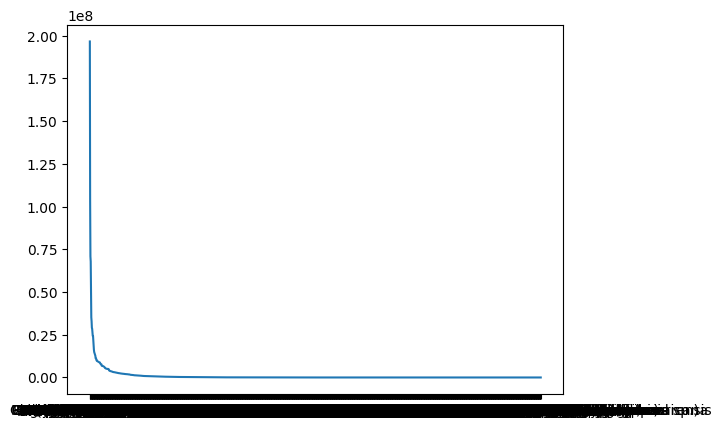

In [8]:
fig, ax = plt.subplots()
ax.plot(results_df['SCIENTIFIC_NAME'], results_df['total_sightings'])

In [24]:
sql = """
WITH species_counts AS (
    SELECT
        scientific_name,
        SUM(CAST(observation_count AS INT)) AS total_sightings
    FROM 'data/ebird_2022.parquet'
    WHERE observation_count != 'X'
    GROUP BY scientific_name
    ORDER BY total_sightings DESC
)
SELECT
    total_sightings,
    count(*) as species,
    SUM(count(*)) OVER (ORDER BY total_sightings DESC) as cumul_species,
    SUM(count(*)) OVER (ORDER BY total_sightings DESC) / SUM(count(*)) OVER () AS pct_cumul_species
FROM species_counts
GROUP BY total_sightings
"""
counts = duckdb.sql(sql)
counts_df = counts.df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [30]:
counts_df['log10_sightings'] = np.log10(counts_df['total_sightings'])
counts_df['log10_species'] = np.log10(counts_df['species'])
counts_df['log10_cumul_species'] = np.log10(counts_df['cumul_species'])
counts_df['log10_pct_cumul_species'] = np.log10(counts_df['pct_cumul_species'])

<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

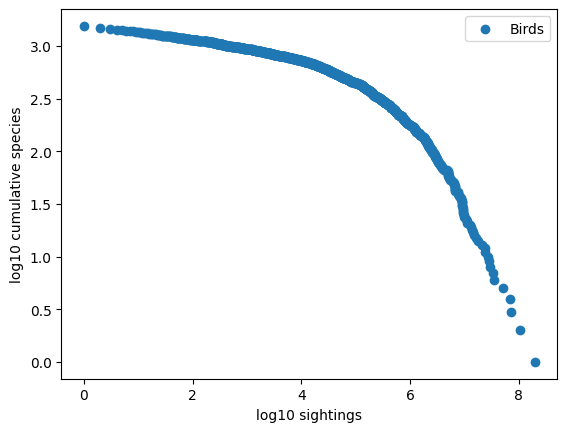

In [27]:
fig, ax = plt.subplots()
ax.scatter(counts_df['log10_sightings'], counts_df['log10_cumul_species'], label='Birds')
ax.set_xlabel('log10 sightings')
ax.set_ylabel('log10 cumulative species')
ax.legend()
fig.show

<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

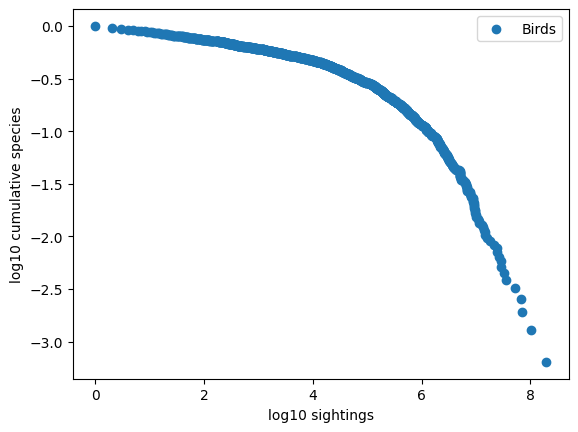

In [31]:
fig, ax = plt.subplots()
ax.scatter(counts_df['log10_sightings'], counts_df['log10_pct_cumul_species'], label='Birds')
ax.set_xlabel('log10 sightings')
ax.set_ylabel('log10 cumulative species')
ax.legend()
fig.show

In [33]:
range_1 = {"min": 0.25, "max": 4}
range_2 = {"min": 6.25, "max": 7.5}

In [13]:


scaling_range_1 = counts_df[(counts_df['log10_sightings'] < range_1["max"]) & (counts_df['log10_sightings'] >= range_1["min"])]
X = sm.add_constant(scaling_range_1['log10_sightings'])
line_1 = sm.OLS(scaling_range_1['log10_cumul_species'], X).fit()

slope_1 = line_1.params.log10_sightings
intercept_1 = line_1.params.const
x_range_1 = scaling_range_1['log10_sightings']
y_range_1 = scaling_range_1['log10_sightings'] * slope_1 + intercept_1

print(line_1.summary2())

                   Results: Ordinary least squares
Model:              OLS                 Adj. R-squared:     0.990     
Dependent Variable: log10_cumul_species AIC:                -3298.6845
Date:               2023-12-13 10:32    BIC:                -3290.3961
No. Observations:   466                 Log-Likelihood:     1651.3    
Df Model:           1                   F-statistic:        4.751e+04 
Df Residuals:       464                 Prob (F-statistic): 0.00      
R-squared:          0.990               Scale:              4.9138e-05
-----------------------------------------------------------------------
                  Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
-----------------------------------------------------------------------
const             3.2403    0.0012  2689.4616  0.0000   3.2380   3.2427
log10_sightings  -0.0907    0.0004  -217.9663  0.0000  -0.0915  -0.0899
----------------------------------------------------------------------
Omnibus:             

In [14]:
scaling_range_2 = counts_df[(counts_df['log10_sightings'] < range_2["max"]) & (counts_df['log10_sightings'] >= range_2["min"])]
X2 = sm.add_constant(scaling_range_2['log10_sightings'])
line_2 = sm.OLS(scaling_range_2['log10_cumul_species'], X2).fit()

slope_2 = line_2.params.log10_sightings
intercept_2 = line_2.params.const
x_range_2 = scaling_range_2['log10_sightings']
y_range_2 = scaling_range_2['log10_sightings'] * slope_2 + intercept_2

print(line_2.summary2())

                   Results: Ordinary least squares
Model:              OLS                 Adj. R-squared:     0.986    
Dependent Variable: log10_cumul_species AIC:                -483.2023
Date:               2023-12-13 10:32    BIC:                -477.4983
No. Observations:   128                 Log-Likelihood:     243.60   
Df Model:           1                   F-statistic:        8643.    
Df Residuals:       126                 Prob (F-statistic): 5.89e-118
R-squared:          0.986               Scale:              0.0013223
----------------------------------------------------------------------
                  Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
----------------------------------------------------------------------
const             8.1710    0.0689  118.5729  0.0000   8.0346   8.3074
log10_sightings  -0.9613    0.0103  -92.9698  0.0000  -0.9818  -0.9408
---------------------------------------------------------------------
Omnibus:                2.513     

In [35]:
scaling_range_clauset = counts_df[(counts_df['log10_sightings'] < range_2["max"]) & (counts_df['log10_sightings'] >= range_2["min"])]
X_clauset = sm.add_constant(scaling_range_clauset['log10_sightings'])
line_clauset = sm.OLS(scaling_range_clauset['log10_pct_cumul_species'], X_clauset).fit()

slope_clauset = line_clauset.params.log10_sightings
intercept_clauset = line_clauset.params.const
x_range_clauset = scaling_range_clauset['log10_sightings']
y_range_clauset = scaling_range_clauset['log10_sightings'] * slope_clauset + intercept_clauset

print(line_clauset.summary2())

                     Results: Ordinary least squares
Model:              OLS                     Adj. R-squared:     0.986    
Dependent Variable: log10_pct_cumul_species AIC:                -483.2023
Date:               2023-12-13 10:46        BIC:                -477.4983
No. Observations:   128                     Log-Likelihood:     243.60   
Df Model:           1                       F-statistic:        8643.    
Df Residuals:       126                     Prob (F-statistic): 5.89e-118
R-squared:          0.986                   Scale:              0.0013223
--------------------------------------------------------------------------
                      Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------------
const                 4.9793    0.0689   72.2563  0.0000   4.8429   5.1156
log10_sightings      -0.9613    0.0103  -92.9698  0.0000  -0.9818  -0.9408
------------------------------------------------------

/var/folders/wp/lq_w646n77jc1slxh2r_13f00000gn/T/ipykernel_12338/2279153709.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


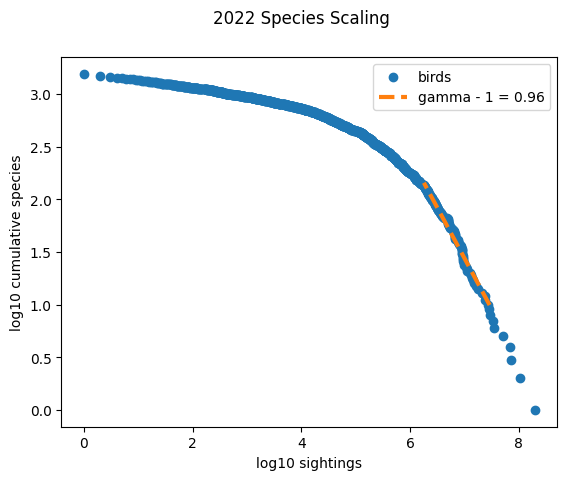

In [22]:
fig, ax = plt.subplots()
ax.scatter(counts_df['log10_sightings'], counts_df['log10_cumul_species'], label='birds')
ax.set_xlabel('log10 sightings')
ax.set_ylabel('log10 cumulative species')


ax.plot(x_range_2, y_range_2, color="tab:orange", linestyle="dashed", linewidth=3, label=f"gamma - 1 = {slope_2*-1:.2f}")
# plt.text(4.5, 1, f"gamma - 1 = {slope_2*-1:.2f}")

ax.legend()

fig.suptitle("2022 Species Scaling")
fig.show()


/var/folders/wp/lq_w646n77jc1slxh2r_13f00000gn/T/ipykernel_12338/3899144626.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


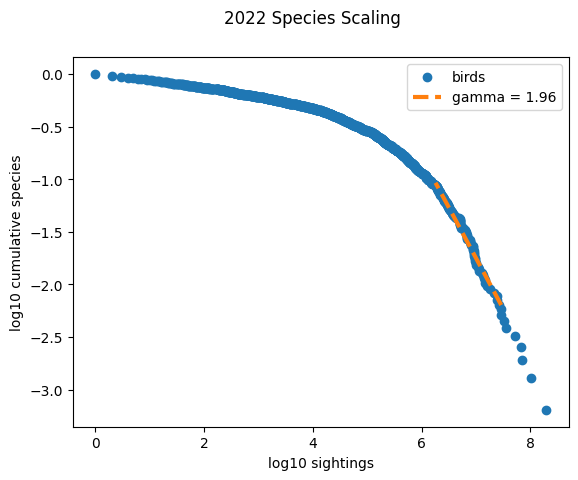

In [39]:
fig, ax = plt.subplots()
ax.scatter(counts_df['log10_sightings'], counts_df['log10_pct_cumul_species'], label='birds')
ax.set_xlabel('log10 sightings')
ax.set_ylabel('log10 cumulative species')


ax.plot(x_range_clauset, y_range_clauset, color="tab:orange", linestyle="dashed", linewidth=3, label=f"gamma = {slope_clauset*-1 + 1:.2f}")
# plt.text(4.5, 1, f"gamma - 1 = {slope_2*-1:.2f}")

ax.legend()

fig.suptitle("2022 Species Scaling")
fig.show()

## Multiyear Species Sighting Scaling

In [16]:
sql = """
WITH species_counts AS (
    SELECT
        scientific_name,
        SUM(CAST(observation_count AS INT)) AS total_sightings
    FROM 'data/ebird_*.parquet'
    WHERE observation_count != 'X'
    GROUP BY scientific_name
    ORDER BY total_sightings DESC
)
SELECT
    total_sightings,
    count(*) as species,
    SUM(count(*)) OVER (ORDER BY total_sightings DESC) as cumul_species
FROM species_counts
GROUP BY total_sightings
"""
multiyear_counts = duckdb.sql(sql)
multiyear_counts_df = multiyear_counts.df()

InvalidInputException: Invalid Input Error: No magic bytes found at end of file 'data/ebird_2013.parquet'

In [ ]:
multiyear_counts_df['log10_sightings'] = np.log10(multiyear_counts_df['total_sightings'])
multiyear_counts_df['log10_species'] = np.log10(multiyear_counts_df['species'])
multiyear_counts_df['log10_cumul_species'] = np.log10(multiyear_counts_df['cumul_species'])
fig, ax = plt.subplots()
ax.scatter(counts_df['log10_sightings'], counts_df['log10_cumul_species'])
ax.scatter(multiyear_counts_df['log10_sightings'], multiyear_counts_df['log10_cumul_species'])
ax.set_xlabel('log10 sightings')
ax.set_ylabel('log10 cumulative species')
fig.suptitle("2022 vs (2020, 2021, 2022) Species Sightings")
fig.show()

In [ ]:
range_1 = {"min": 0.25, "max": 4}
range_2 = {"min": 6.5, "max": 8}



scaling_range_1 = multiyear_counts_df[(multiyear_counts_df['log10_sightings'] < range_1["max"]) & (multiyear_counts_df['log10_sightings'] >= range_1["min"])]
X = sm.add_constant(scaling_range_1['log10_sightings'])
line_1 = sm.OLS(scaling_range_1['log10_cumul_species'], X).fit()

slope_1 = line_1.params.log10_sightings
intercept_1 = line_1.params.const
x_range_1 = scaling_range_1['log10_sightings']
y_range_1 = scaling_range_1['log10_sightings'] * slope_1 + intercept_1

print(line_1.summary2())
print("\n\n\n\n")
scaling_range_2 = multiyear_counts_df[(multiyear_counts_df['log10_sightings'] < range_2["max"]) & (multiyear_counts_df['log10_sightings'] >= range_2["min"])]
X2 = sm.add_constant(scaling_range_2['log10_sightings'])
line_2 = sm.OLS(scaling_range_2['log10_cumul_species'], X2).fit()

slope_2 = line_2.params.log10_sightings
intercept_2 = line_2.params.const
x_range_2 = scaling_range_2['log10_sightings']
y_range_2 = scaling_range_2['log10_sightings'] * slope_2 + intercept_2

print(line_2.summary2())


In [ ]:
fig, ax = plt.subplots()
ax.scatter(multiyear_counts_df['log10_sightings'], multiyear_counts_df['log10_cumul_species'])
ax.set_xlabel('log10 sightings')
ax.set_ylabel('log10 cumulative species')

# Plot linear fit for first range
ax.plot(x_range_1, y_range_1, color="tab:orange", linewidth=5)
plt.text(0.5, 2.5, f"gamma - 1 = {slope_1*-1:.2f}")

ax.plot(x_range_2, y_range_2, color="tab:pink", linewidth=5)
plt.text(4.5, 1, f"gamma - 1 = {slope_2*-1:.2f}")

fig.suptitle("Multiyear Species Scaling")
fig.show()